<div class="alert alert-block alert-info">

----------
---------
# <b> ResNet-50 Binary Classification </b> 

--------------
----------------
</div>

This notebook contains a clean and structured implementation of a **ResNet-50 baseline model** for binary corrosion classification. The model uses ImageNet pre-trained weights and trains only the final fully connected layer.

<div class="alert alert-block alert-info">

----------
---------
# <b> 1. Imports and Reproducibility</b> 

--------------
----------------
</div>

In [2]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from PIL import ImageFile
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

ImageFile.LOAD_TRUNCATED_IMAGES = True # Allowing loading of truncated or corrupted images without crashing

# Fixing random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


<div class="alert alert-block alert-info">

----------
---------
# <b> 2. Paths and Device Setup</b> 

--------------
----------------
</div>

In [ ]:
DATA_DIR = Path("/home/shared-data/corrosion_images") # Paths 

PROJECT_DIR = Path("/home/javid/corrosion-detector-submission")
SPLIT_PATH  = PROJECT_DIR / "data" / "fixed_split_indices.npy"
MODELS_DIR = PROJECT_DIR / "models"
RESULTS_DIR = PROJECT_DIR / "results"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32 # Training parameters 
EPOCHS = 50
PATIENCE = 5
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cuda


<div class="alert alert-block alert-info">

----------
---------
# <b> 3. Image Transformations</b> 

--------------
----------------
</div>

In order to ensure compatibility with the ResNet-50 architecture, input images are scaled to 224 × 224 pixels and standardized based on ImageNet’s mean and deviation.

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

<div class="alert alert-block alert-info">

----------
---------
# <b> 4. Dataset Loading and Splitting</b> 

--------------
----------------
</div>

##### **_4.1 Loading Dataset_**


In [ ]:
print("Loading dataset...")
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

class_names = dataset.classes  # storing class names for later use

print(f"Total images: {len(dataset)}")
print(f"Classes: {class_names}")


Loading dataset...
Total images: 3999
Classes: ['corrosion', 'no_corrosion']


##### **_4.2 Loading Fixed Train / Val / Test Split_**


In [6]:
print("Loading fixed data split...")
split = np.load(SPLIT_PATH, allow_pickle=True).item()

train_ds = Subset(dataset, split["train"])
val_ds   = Subset(dataset, split["val"])
test_ds  = Subset(dataset, split["test"])

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")



Loading fixed data split...
Train: 3199 | Val: 400 | Test: 400


<div class="alert alert-block alert-info">

----------
---------
# <b> 5. DataLoaders</b> 

--------------
----------------
</div>

In [7]:
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False
)


<div class="alert alert-block alert-info">

----------
---------
# <b> 6. Model Definition (ResNet-50)</b> 

--------------
----------------
</div>

In [ ]:
print("Loading ResNet-50 (ImageNet pretrained)...")

model = models.resnet50(
    weights=models.ResNet50_Weights.IMAGENET1K_V2
)

for param in model.parameters(): # Freezing all backbone layers
    param.requires_grad = False

num_features = model.fc.in_features # Replacing final layer for binary classification
model.fc = nn.Linear(num_features, 2)

model = model.to(DEVICE)


Loading ResNet-50 (ImageNet pretrained)...


<div class="alert alert-block alert-info">

----------
---------
# <b> 7. Training Setup</b> 

--------------
----------------
</div>

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR)

MODEL_PATH = MODELS_DIR / "resnet50_binary_baseline_best.pth"
HISTORY_PATH = RESULTS_DIR / "resnet50_binary_baseline_training_history.csv"

best_val_acc = 0.0
patience_left = PATIENCE

history = []


<div class="alert alert-block alert-info">

----------
---------
# <b> 8. Training Loop with Early Stopping</b> 

--------------
----------------
</div>

In [ ]:
start_time = time.time()


for epoch in range(EPOCHS):     # Training 
    model.train()      
    train_loss, train_correct, train_total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        train_total += y.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()     # Validation
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)

            val_loss += loss.item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Acc: {train_acc*100:.2f}% | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    history.append({
        "epoch": epoch + 1,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_left = PATIENCE
        torch.save(model.state_dict(), MODEL_PATH)
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping triggered.")
            break

elapsed = (time.time() - start_time) / 60
print(f"Training finished in {elapsed:.1f} minutes.")


Epoch 01 | Train Acc: 87.90% | Val Acc: 90.50% | Train Loss: 0.3470 | Val Loss: 0.2406
Epoch 02 | Train Acc: 92.72% | Val Acc: 94.50% | Train Loss: 0.2070 | Val Loss: 0.1806
Epoch 03 | Train Acc: 93.81% | Val Acc: 95.50% | Train Loss: 0.1778 | Val Loss: 0.1528
Epoch 04 | Train Acc: 94.19% | Val Acc: 95.50% | Train Loss: 0.1625 | Val Loss: 0.1461
Epoch 05 | Train Acc: 95.19% | Val Acc: 95.75% | Train Loss: 0.1450 | Val Loss: 0.1462
Epoch 06 | Train Acc: 95.81% | Val Acc: 95.00% | Train Loss: 0.1301 | Val Loss: 0.1353
Epoch 07 | Train Acc: 96.31% | Val Acc: 94.75% | Train Loss: 0.1240 | Val Loss: 0.1339
Epoch 08 | Train Acc: 95.84% | Val Acc: 95.50% | Train Loss: 0.1248 | Val Loss: 0.1329
Epoch 09 | Train Acc: 96.12% | Val Acc: 95.00% | Train Loss: 0.1158 | Val Loss: 0.1351
Epoch 10 | Train Acc: 96.84% | Val Acc: 95.75% | Train Loss: 0.1057 | Val Loss: 0.1301
Early stopping triggered.
Training finished in 34.1 minutes.


##### **_8.1 Save Training History_**


In [11]:
import pandas as pd
history_df = pd.DataFrame(history)
history_df.to_csv(HISTORY_PATH, index=False)

print(f"Training history saved to: {HISTORY_PATH}")


Training history saved to: /home/javid/corrosion-detector-submission/results/resnet50_binary_baseline_training_history.csv


##### **_8.2 Plotting Training & Validation Loss Curves_**


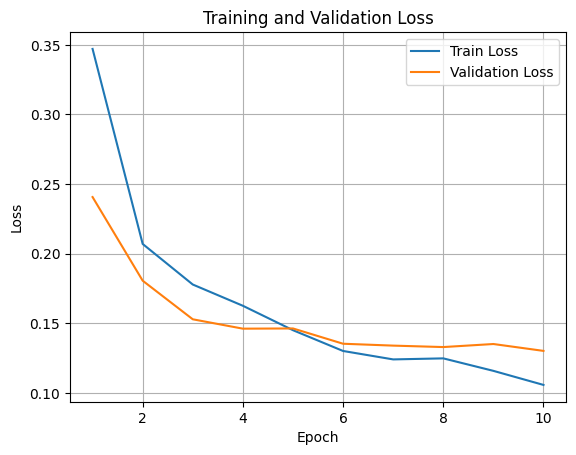

In [12]:
plt.figure()
plt.plot(history_df["epoch"], history_df["train_loss"], label="Train Loss")
plt.plot(history_df["epoch"], history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

----------
---------
# <b> 9. Test Evaluation and Confusion Matrix</b> 

--------------
----------------
</div>

##### **_9.1 Loadiing best model and collecting the predictions_**


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

print("Predictions collected for test set.")


Predictions collected for test set.


##### **_9.2 Test Accuracy + Precision / Recall / F1-score_**


In [ ]:
test_acc = accuracy_score(y_true, y_pred) * 100 #  Test accuracy
print(f"Test Accuracy: {test_acc:.2f}%\n")

print("Classification Report:") # Detailed classification report
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    )
)


Test Accuracy: 94.00%

Classification Report:
              precision    recall  f1-score   support

   corrosion     0.9667    0.9062    0.9355       192
no_corrosion     0.9182    0.9712    0.9439       208

    accuracy                         0.9400       400
   macro avg     0.9424    0.9387    0.9397       400
weighted avg     0.9415    0.9400    0.9399       400



##### **_9.3: Confusion Matrix_**


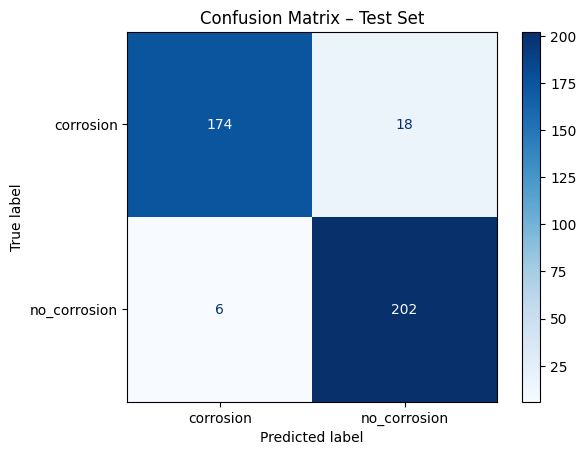

In [15]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()
